In [1]:
"""LiuKatrina_09.ipynb Harvard MCB 112 Problem Set 09: the return of the ten Arcs submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Nov 2, 2022"

In [2]:
import numpy as np
import string
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def get_data(filename):
    # Parse the input file. Code adopted from w09-naive.py on mcb112.org website
    #
    with open(filename) as f:
        #   The first line is "The <n> transcripts of the sand mouse Arc locus"
        line  = f.readline()
        match = re.search(r'^The (\d+) transcripts', line)
        T     = int(match.group(1))

        # The next T lines are 
        #   <Arcn>  <true_tau> <L> <structure>
        # tau's may be present, or obscured ("xxxxx")
        tau       = np.zeros(T)
        L         = np.zeros(T).astype(int)
        tau_known = True   # until we see otherwise
        for i in range(T):
            fields    = f.readline().split()
            if fields[1] == "xxxxx":
                tau_known = False
            else:
                tau[i] = float(fields[1])
            L[i]      = int(fields[2])

        # after a blank line,
        # 'The <n> read sequences':
        line  = f.readline()
        line  = f.readline()
        match = re.search(r'The (\d+) read sequences', line)
        N     = int(match.group(1))

        # the next T lines are 
        #  <read a-j> <count>
        r = np.zeros(T).astype(int)
        for k in range(T):
            fields = f.readline().split()
            r[k]   = fields[1]


    S = T    # S = R = T : there are T transcripts (Arc1..Arc10), S segments (A..J), R reads (a..j)
    R = T
    Slabel   = list(string.ascii_uppercase)[:S]               # ['A'..'J']        : the upper case labels for Arc locus segments 
    Tlabel   = [ "Arc{}".format(d) for d in range(1,T+1) ]    # ['Arc1'..'Arc10'] : the labels for Arc transcript isoforms
    Rlabel   = list(string.ascii_lowercase)[:T]               # ['a'..'j']        : lower case labels for reads


    # Count how often each segment A..J is used in the isoforms i
    # We'll use that to split observed read counts across the isoforms
    # that they might have come from.
    #
    segusage = np.zeros(S).astype(int)
    for i in range(T):
        for j in range(i,i+L[i]): 
            segusage[j%S] += 1
    return Tlabel, Slabel, Rlabel, N, r,segusage,tau_known,tau,L



In [4]:
# Obtain the data from the example file, we will be using the data
# from the example to test our generative model and the calculation
# of log likelihood.
Tlabel, Slabel, Rlabel, N, r,segusage,tau_known,tau,L=get_data("w09-example.out")
Tlabel, Slabel, Rlabel, N, r,segusage,tau_known,tau,L

(['Arc1',
  'Arc2',
  'Arc3',
  'Arc4',
  'Arc5',
  'Arc6',
  'Arc7',
  'Arc8',
  'Arc9',
  'Arc10'],
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'],
 1000000,
 array([101808, 183489, 186342,  86295,  92872,  48564,  15523,  87426,
        113901,  83780]),
 array([3, 3, 3, 2, 3, 3, 3, 3, 2, 2]),
 True,
 array([0.046, 0.293, 0.128, 0.089, 0.017, 0.017, 0.006, 0.196, 0.089,
        0.12 ]),
 array([3, 2, 3, 3, 3, 3, 2, 2, 3, 3]))

# Exercise 1: Postive Control: the Generative Model
Our generative model follows the below procedure:
- Choose the transcript isoform $T_i$ with probabilty $v_i$ where $\vec{v}$ is the nucleotide abundance levels.
- Uniformly choose one of segments $S_j$ from the segments of isoform $T_i$. 

After defining the algorithm, we will first write some helper functions to facilitate the conversions between transcript abundance levels and nucleotide abundance levels.

In [5]:
def get_nuc_abundances(tau,lengths):
    """
    Convert the nucleotide abundances from the transcript abundances
    :param tau: a list of transcript abundance levels for each transcript isoform
    :param lengths: a list of transcript lengths
    :return: a list of nucleotide abundance levels for each transcript isoform
    """
    abund = np.multiply(tau,lengths)
    return abund/abund.sum()

def get_transcript_abundances(nuc_abunds,lengths):
    """
    Convert the transcript abundances from the nucleotide abundances
    :param nuc_abunds: a list of nucleotide abundance levels for each transcript isoform
    :param lengths: a list of transcript lengths
    :return: a list of transcript abundance levels for each transcript isoform
    """
    tau_raw = np.divide(nuc_abunds,lengths)
    return tau_raw/sum(tau_raw)


Then, we will be able to generate the reads. 

In [6]:

def count_reads(sample_reads,s_num=10):
    """
    Count the number of each reads from a list of reads
    :param sample_reads: a list of generated reads
    :param s_num: number of different segments
    :return: the count of each read from the sample reads
    """
    return np.array([np.count_nonzero(sample_reads==i) for i in range(s_num)])

def generate_read_counts(tau,lengths,s_num=10,read_num=1000000):
    """
    Generate reads based on the input transcript abundances and transcript lengths
    :param tau: a list of transcript abundance levels for each transcript isoform
    :param lengths: a list of transcript lengths
    :param s_num: number of different segments
    :paran read_num: number of reads to be generated
    :return: a list of generated reads, the count of each read from the sample reads
    """
    t_num = len(lengths)
    abunds = get_nuc_abundances(tau,lengths)
    sample_isoforms = np.random.choice(t_num,read_num,p=abunds)
    sample_segments = [(np.random.choice(lengths[i])+i)%s_num for i in sample_isoforms]
    sample_segments = np.array(sample_segments)
    return sample_segments, count_reads(sample_segments,s_num)

Now, we can generate a test read data.

In [7]:
# Known parameters
print("The tau we used to generate the reads are: ", tau)
print("The transcript lengths we used to generate the reads are: ",L)
# Generate the reads
rs = generate_read_counts(tau,L,10,1000000)
print("The generated reads are ", rs[0])
print("The counts for each read are \n",pd.DataFrame(rs[1],index=Rlabel, columns=["count"]))

The tau we used to generate the reads are:  [0.046 0.293 0.128 0.089 0.017 0.017 0.006 0.196 0.089 0.12 ]
The transcript lengths we used to generate the reads are:  [3 2 3 3 3 3 2 2 3 3]
The generated reads are  [2 2 4 ... 1 4 2]
The counts for each read are 
     count
a  101850
b  182839
c  186287
d   86346
e   92490
f   49118
g   15974
h   87618
i  114027
j   83451


# Exercise 2: Log Likelihood
First, we need a function to find the segments related to each transcript isoforms based on their lengths.

In [8]:
def get_transcript_isoforms(lengths,s_num=10):
    """
    Get the segments contained in each transcript isoforms
    :param lengths: a list of transcript lengths
    :param s_num: number of different segments
    :return: a 2d-list of the segment indices each transcript contains
    """
    isoforms = []
    for i in range(len(lengths)):
        isoform = []
        for j in range(lengths[i]):
            isoform.append((i+j)%s_num)
        isoforms.append(isoform)
    return isoforms


We write $P(S,T|\vec{v},{L})$ to represent the probability of segment S was generated from the selected transcript isoform T given the nucleotide abundance levels and transcript lengths.
$$P(S_j,T_i|\vec{v},\vec{L}) = P(S_j|T_i,\vec{L})P(T_i|\vec{v}) = \dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i})$$
Since the value of $T_i$ is solely dependent on $v_{i}$ and $L_{i}$ and independent with the rest of values in $\vec{v}$ and $\vec{L}$, $$P(S_j,T_i|\vec{v},\vec{L}) = P(S_i,T_i|v_i,L_i).$$
For this distribution, if we marginalize over the transcripts r.v., $T_{i}$, we will get the probability of generating a read of segment $S_j$, $P(S_j|\vec{v},\vec{L})$, to be equal to $$P(S_j|\vec{v},\vec{L}) = \sum_{i=1}^n P(S_j,T_i|v_i,L_i).$$
Since each read is generated independently, the probability of generating $c_j$ many read $S_j$, $$P(c_j|\vec{v},\vec{L}) =P(S_j|\vec{v},\vec{L})^{c_j}= (\sum_{i=1}^n P(S_j,T_i|v_i,L_i))^{c_j}$$
(Note: Here we use n to denote number of segments and transcripts because they are the same. But essentially, n asscosiated with i would be denoting the number of transcript isoforms, and n associated with j would be denoting the number of segments. This notation is being used through out the entire submission.)

Then, the likelihood of observing read counts $c_1,...c_n$, $P(c_1, c_2,....,c_n|\vec{v},\vec{L})$, can be reformated into $$P(c_1, c_2,....,c_n|\vec{v},\vec{L}) = \prod_{j=1}^n P(c_{j}|\vec{v},\vec{L})=\prod_{j=1}^n P(S_{j}|\vec{v},\vec{L})^{c_j} = \prod_{j=1}^n (\sum_{i=1}^n P(S_j, T_{i}|v_i,L_i))^{c_j} $$
Substituting in what we had before, we have $$P(c_1, c_2,....,c_n|\vec{v},\vec{L})= \prod_{j=1}^n (\sum_{i=1}^n \dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i}))^{c_j}=\prod_{j=1}^n (\sum_{i=1}^n \dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i}))^{c_j}$$
Then, our log likelihood is $$\log P(c_1, c_2,....,c_n|\vec{v},\vec{L}) = \sum_{j=1}^n c_j\log (\sum_{i=1}^n \dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i}))$$

In [9]:
def log_likelihood(read_counts,transcript_isoforms,nuc_abunds,lengths):
    """
    Calculate the log likelihood of observing read counts based on given abundances and
    transcripts
    :param read_counts: a list of counts of each read
    :param transcript_isoforms: a 2d-list of the segment indices each transcript contains
    :param nuc_abunds: a list of nucleotide abundance levels for each transcript isoform
    :param lengths: a list of transcript lengths
    :return: the log likelihood of observing read counts based on the given parameters
    """
    s_num = len(read_counts)
    t_num = len(transcript_isoforms)
    total_log_likelihood = 0
    for s in range(s_num):
        read_prob = 0
        for t in range(t_num):
            if s in transcript_isoforms[t]:
                read_prob += np.divide(nuc_abunds[t],lengths[t])
        total_log_likelihood += np.log(read_prob)*read_counts[s]
    return total_log_likelihood

Then, we want to compare the results of Lestrade's method.

In [10]:
def lestrade_method(T,S,L,segusage,r): 
    # Code adopted from w09-naive.py on mcb112.org
    # Naive analysis:
    #
    c  = np.zeros(T)
    for i in range(T):
        for k in range(i,i+L[i]):
            c[i] += (1.0 / float(segusage[k%S])) * float(r[k%S])  # For each read k, assume read k-> segment j,
                                                                # and assign 1/usage count to each transcript
                                                                # that contains segment j.
    Z       = np.sum(c)
    est_nu  = np.divide(c, Z)       # nucleotide abundance

    est_tau = np.divide(est_nu, L)  # convert to TPM, transcript abundance
    est_tau = np.divide(est_tau, np.sum(est_tau))
    return est_tau

We test it first with the read counts from the example file.

In [11]:
print("The counts from the example file are \n",pd.DataFrame(r,index=Rlabel, columns=["count"]))

The counts from the example file are 
     count
a  101808
b  183489
c  186342
d   86295
e   92872
f   48564
g   15523
h   87426
i  113901
j   83780


In [12]:
# Get Lestrade's parameters
print("True tau is:", tau)
lestrade_tau=lestrade_method(10,10,L,segusage,r)
print("Lestrade estimated tau to be: ", lestrade_tau)
lestrade_nuc_abunds = get_nuc_abundances(lestrade_tau,L)

# Get fixed parameters
ts = get_transcript_isoforms(L)
true_nuc_abunds = get_nuc_abundances(tau,L)

# Get log likelihoods
lestrade_ll = log_likelihood(r,ts,lestrade_nuc_abunds,L)
true_ll = log_likelihood(r,ts,get_nuc_abundances(tau,L),L)

# Summarize the results
print("We obtained a log likelihood of %f based on the tau Lestrade calculated."%lestrade_ll)
print("We obtained a log likelihood of %f based on the true tau."%true_ll)
print("We observed a difference of %f in the log likelihood, indicating the true tau is that "+
    "much more likely than Lestrades result."%(true_ll-lestrade_ll))

True tau is: [0.046 0.293 0.128 0.089 0.017 0.017 0.006 0.196 0.089 0.12 ]
Lestrade estimated tau to be:  [0.14013816 0.1648319  0.12142416 0.08048616 0.04663725 0.04501908
 0.04588387 0.11511304 0.1183557  0.12211068]
We obtained a log likelihood of -2203735.731137 based on the tau Lestrade calculated.
We obtained a log likelihood of -2168747.221869 based on the true tau.
We observed a difference of %f in the log likelihood, indicating the true tau is that much more likely than Lestrades result.


Then, we test it based on the read count data set we generated in exercise 1.

In [13]:
# Get Lestrade's parameters
print("True tau is:", tau)
lestrade_tau=lestrade_method(10,10,L,segusage,rs[1])
print("Lestrade estimated tau to be: ", lestrade_tau)
lestrade_nuc_abunds = get_nuc_abundances(lestrade_tau,L)

# Get fixed parameters
ts = get_transcript_isoforms(L)
true_nuc_abunds = get_nuc_abundances(tau,L)

# Get log likelihoods
lestrade_test_ll = log_likelihood(rs[1],ts,lestrade_nuc_abunds,L)
true_test_ll = log_likelihood(rs[1],ts,get_nuc_abundances(tau,L),L)

# Summarize the results
print("We obtained a log likelihood of %f based on the tau Lestrade calculated."%lestrade_test_ll)
print("We obtained a log likelihood of %f based on the true tau."%true_test_ll)
print("We observed a difference of %f in the log likelihood, indicating the true tau is that "+
    "much more likely than Lestrades result."%(true_ll-lestrade_ll))

True tau is: [0.046 0.293 0.128 0.089 0.017 0.017 0.006 0.196 0.089 0.12 ]
Lestrade estimated tau to be:  [0.13993453 0.16450989 0.12131129 0.08055618 0.04682014 0.04537259
 0.04616827 0.11527739 0.11827209 0.12177762]
We obtained a log likelihood of -2204842.489269 based on the tau Lestrade calculated.
We obtained a log likelihood of -2170327.055240 based on the true tau.
We observed a difference of %f in the log likelihood, indicating the true tau is that much more likely than Lestrades result.


# Exercise 3: Isoform Abundances via EM
The use of the EM algorithm can be described as the following:
- **Expection**: We are trying to obtain the expectation transcript counts from the observed read counts, the abundance levels, and the lengths of the transcript. 
    - $P(T|S,\vec{v},\vec{L})$: the probability of one observed segment S is generated from transcript isoform T given the nucleotide abundances, and the transcript lengths.
    - By Bayes' rule: $$P(T|S,\vec{v},\vec{L}) = \dfrac{P(S,T|\vec{v},\vec{L})}{P(S|\vec{v},\vec{L})} = \dfrac{P(S,T|\vec{v},\vec{L})}{\sum_{i=1}^n P(S,T_i|\vec{v},\vec{L})}.$$ Since we have already calculated $P(S,T|\vec{v},\vec{L})$ is exercise 2, we will directly use the result of $$P(S_j,T_i|\vec{v},\vec{L})=\dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i}).$$ 
    - Therefore, the expected counts of transcript $T_i$ from one segment $S_j$ would be $$E(c_{T_i}|S_j,\vec{v},\vec{L}) =P(T_i|S_j,\vec{v},\vec{L})= \dfrac{\dfrac{v_{i}}{L_{i}}\delta(S_j\in T_{i})}{\sum_{i'=1}^n \dfrac{v_{i'}}{L_{i'}}\delta(S_j\in T_{i'})} $$ Then, $$E(c_{T_i}|\vec{c_{S_j}},\vec{v},\vec{L}) = c_{S_j}E(T_i|S_j,\vec{v},\vec{L})=c_{S_j}P(T_i|S_j,\vec{v},\vec{L})$$
    The total count of transcript $T_i$ would be $$E(c_{T_i}|\vec{v},\vec{L}) = \sum_{j=1}^n c_{S_j}E(T_i|S_j,\vec{v},\vec{L}) = \sum_{j=1}^n c_{S_j}P(T_i|S_j,\vec{v},\vec{L}) = \sum_{j=1}^n c_{S_j}\dfrac{P(S_j,T_i|\vec{v},\vec{L})}{\sum_{i=1}^n P(S_j,T_i|\vec{v},\vec{L})} $$
- **Maximization**: We are trying to update the abundance levels from the newly calculated expected transcript counts. The transcript counts represents how many observed reads are mapped to each of the transcripts isoforms. Then, the updated nucleotide abundances would just be $$v_i = \dfrac{c_{T_i}}{\sum_{i'=1}^n c_{T_i'}}$$

In [14]:
def expectation(nuc_abunds,read_counts,lengths,transcript_isoforms):
    """
    Obtain the expected segments mapped to each segments
    :param nuc_abunds: a list of nucleotide abundance levels for each transcript isoform
    :param read_counts: a list of counts of each read
    :param lengths: a list of transcript lengths
    :param transcript_isoforms: a 2d-list of the segment indices each transcript contains
    :return: a list of the expected count of segments mapped to each transcript isoform
    """
    t_num = len(nuc_abunds)
    s_num = len(read_counts)
    count_arr = np.zeros(t_num)
    for s in range(s_num):
        read_prob_list = np.zeros(t_num)
        s_usage = []
        for t in range(t_num):
            if s in transcript_isoforms[t]:
                s_usage.append(t)
                read_prob_list[t] = nuc_abunds[t]/lengths[t]
        read_prob_list = np.divide(read_prob_list, sum(read_prob_list))
        total_read_counts = np.multiply(read_prob_list,read_counts[s])
        for t in s_usage:
            count_arr[t] += total_read_counts[t]
    return count_arr
    
def maximizaton(transcript_counts):
    """
    Update nucleotide abundance levels
    :param transcript_counts: a list of the expected count of segments mapped to each transcript isoform
    :return: a list of nucleotide abundance levels for each transcript isoform
    """
    nuc_abunds = transcript_counts/sum(transcript_counts)
    return nuc_abunds

In [15]:
def EM(read_counts,lengths, max_iter = 5000, threshold=0.01):
    """
    Run expectation and maximization algorithm to obtain the tau values
    :param read_counts: a list of counts of each read
    :param lengths: a list of transcript lengths
    :param max_iters: the maximum number iterations of EM allowed
    :param threshold: the difference threshold of log likelihood for convergence
    :return: a list of log likelihoods for each iteration, the final transcript abundance levels
    """
    s_num = len(read_counts)
    t_num = len(lengths)
    ts = get_transcript_isoforms(lengths,s_num)
    initial_nuc_abunds = np.random.rand(10)
    nuc_abunds = initial_nuc_abunds/ sum(initial_nuc_abunds)
    ll = [log_likelihood(read_counts,ts,nuc_abunds,lengths)]
    for _ in range(max_iter):
        tc = expectation(nuc_abunds,read_counts,lengths,ts)
        nuc_abunds = maximizaton(tc)
        new_ll = log_likelihood(read_counts,ts,nuc_abunds,lengths)
        prev_ll = ll[-1]
        ll.append(new_ll)
        if np.abs(new_ll - prev_ll) <= threshold:
            break
    return ll, get_transcript_abundances(nuc_abunds,lengths)


Here, we have assembled our EM algorithm, we will first test it on the example data set.

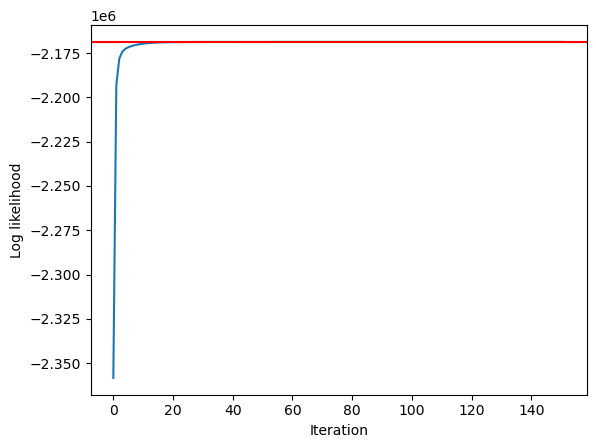

In [16]:
# Test EM on the example dataset
lls_em, tau_em = EM(r,L)
plt.plot(range(len(lls_em)),lls_em, label="EM ll")
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.axhline(true_ll, color="r", label="True ll")
plt.show()


We see that our EM algorithm calculates the parameters which quickly make the log likelihood converge. 

Next, we perform it on the data from the `w09-data.out` file.

In [17]:
# Read the data from the w09-data.out file
Tlabel_d, Slabel_d, Rlabel_d, N_d, r_d,segusage_d,tau_known_d,tau_d,L_d = get_data("w09-data.out")
Tlabel_d, Slabel_d, Rlabel_d, N_d, r_d,segusage_d,tau_known_d,tau_d,L_d

(['Arc1',
  'Arc2',
  'Arc3',
  'Arc4',
  'Arc5',
  'Arc6',
  'Arc7',
  'Arc8',
  'Arc9',
  'Arc10'],
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'],
 1000000,
 array([ 97512, 268771, 249157,  76643,  33977,  40729,  43351,  76299,
         73029,  40532]),
 array([3, 3, 3, 3, 3, 3, 4, 4, 2, 2]),
 False,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([4, 2, 3, 4, 4, 3, 2, 2, 3, 3]))

In [18]:
# Run EM algorithm to obtain the transcript abundances
lls, tau_d = EM(r_d,L_d)
tau_df = pd.DataFrame(tau_d,index=Tlabel_d,columns=["tau"])
print("The transcript abundances obtained by the EM algorithm are \n", tau_df)
print("The log likelihood is %f." % lls[-1])
sort_tau_df = tau_df.sort_values(by=["tau"],ascending=False)
print("The most two abundant transcripts are \n", sort_tau_df[:2])
print("They have accounted for %f of the read population." %(sum(sort_tau_df[:2].values)))
print("The least two abundant transcripts are \n", sort_tau_df[-2:])

The transcript abundances obtained by the EM algorithm are 
             tau
Arc1   0.146507
Arc2   0.496933
Arc3   0.003992
Arc4   0.048697
Arc5   0.035288
Arc6   0.021704
Arc7   0.006393
Arc8   0.134880
Arc9   0.053977
Arc10  0.051629
The log likelihood is -2021936.788865.
The most two abundant transcripts are 
            tau
Arc2  0.496933
Arc1  0.146507
They have accounted for 0.643440 of the read population.
The least two abundant transcripts are 
            tau
Arc7  0.006393
Arc3  0.003992


The conclusion of Lestrade et al. where Arc2 and Arc3 are strongly on is inaccurate. The reason behind this is that Lestrade et al. only take into account that for each read, the probabilities of generating it with the selection of each transcript isoform, $P(S,T_i|\vec{v},\vec{L})$, are not even among the transcripts, so they cannot assume even probability and simply evenly distributed to each transcript that is capable to generating S. We see this from the generative model that $$P(S,T_i|\vec{v},\vec{L}) = P(S|T_i,\vec{L})P(T_i|\vec{v}, \vec{L}) = \dfrac{v_i}{L_i}\delta(S\in T_i)$$ Indicates we cannot directly use $\dfrac{1}{segusage(S)}$ as the probability of S is generated from transcript $T_i$ where S is in $T_i$. Therefore, Lestrade et al.'s method is incorrect.